In [1]:
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display, Latex

# from numba import jit

# numpy 
import numpy as np_
import scipy as sp

import random

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires = 2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [2]:
# == Global paras ==
Paras_global, Phi_global, Gamma_ps  = np_.zeros(6), 0, 0

# Return one by one
def Dephase_factor(tau):
    Calculate_Dephase = 1 - np.exp(-2 * tau)
    
    return Calculate_Dephase

$$
\rho_{After-Hadamard} = 

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

where,
\quad \gamma = 
1 - e^{-2 \tau}
$$


$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [3]:
# == Generate circuit ==

# circuit_1
@qml.qnode(dev)
def circuit_1(paras):
    # Call global phi
    global Phi_global
    phi = Phi_global
    
    # Assign paras
    theta_init, tau_1, tau_2 = paras[0], paras[1], paras[2]
    
    # Calculate dephase factor with given paras
    gamma_dephase_in = np_.zeros(3)
    for i in range(3):
        gamma_dephase_in[i] = Dephase_factor(paras[i+3])
        
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    qml.PhaseDamping(gamma_dephase_in[0], wires = 0)
    qml.PhaseDamping(gamma_dephase_in[0], wires = 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)
    qml.PhaseDamping(gamma_dephase_in[1], wires = 0)
    qml.PhaseDamping(gamma_dephase_in[1], wires = 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in[2], wires = 0)
    qml.PhaseDamping(gamma_dephase_in[2], wires = 1)
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])


# Circuit_2: Calculate decoherence by using [tau -> gamma_dephase_in] conversion
@qml.qnode(dev)
def Post_selection_Dephase(phi):
    
    # theta_init, tau_1, tau_2, gamma_1, gamma_2, gamma_3 = paras[0], paras[1], paras[2], paras[3], paras[4], paras[5]
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit_1(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])  

$$ K =  \begin{bmatrix}
\sqrt{1-\gamma} & 0 \\
0 & 1 
\end{bmatrix}  $$


$$
\rho_{ps} = 
\frac{(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})}

{Tr[(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})]}
$$

![Alt text](image-1.png)

In [4]:
# == Cost function ==
def Cost_function(paras):
    # expect: theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3 = paras[0], paras[1], paras[2], paras[3], paras[4], paras[5]
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [5]:
# == Check for maximum tau <-> gamma ==
tau_test = 18

print('Gamma =', Dephase_factor(tau_test), ', [ at tau =',tau_test,']' )

Gamma = 0.9999999999999998 , [ at tau = 18 ]


In [6]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # Set Data index
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            Constraints = [(-float('inf'), float('inf'))] * 3 + [(1e-100, tau_upper)] * 3
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

Data = 

array([ [PHI_0, CFI_0, theta_0, tau_1, tau_2, tau_d1, tau_d2, tau_d3], 

...

In [7]:
# == Fixed to gamma_ps = 0.8 ==

# == Sweep for 0 ~ pi*3 == 
Step = np.pi/25     #1e-1
Sweep_data = np_.array([1e-4, np.pi * 6 + 1e-4, Step])

Para_init = np_.zeros(6)
Para_init[:3], Para_init[3:] = random.uniform(0, 1), random.uniform(1e-2, 0)

Gamma_ps_preset = 0.8
Set_Iterations = 6

Optimized_Result = BFGS(Sweep_data, Para_init, Gamma_ps_preset, Set_Iterations)

In [8]:
# Optimized_Result[:, 0]

# layer = 0 & test_case = 3.01000000e-01
Current_Layer = 1
Optimized_Result[Current_Layer][3, :]

# Optimized_Result[0][:,:]

array([ 3.77091118e-001,  9.99990188e+001,  1.17511108e-009,
       -3.77542989e-001,  4.00701539e-001,  1.00000000e-100,
        1.00000000e-100,  1.00000000e-100])

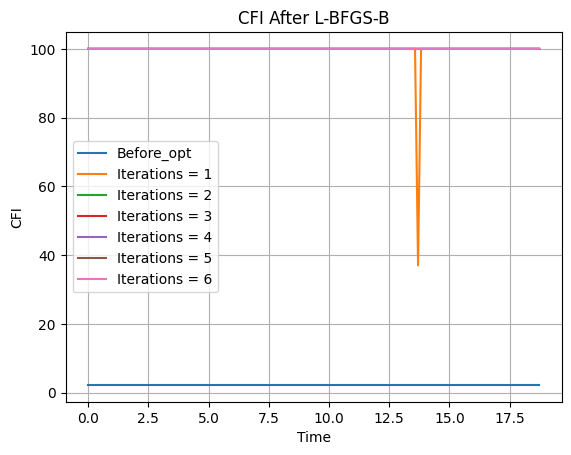

In [9]:
plt.plot(Optimized_Result[0, : ,0], Optimized_Result[0, : ,1], label = 'Before_opt')
for i in range(1, Set_Iterations + 1):
    plt.plot(Optimized_Result[0, :, 0], Optimized_Result[i, :, 1], label = f'Iterations = {i}')
    
plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

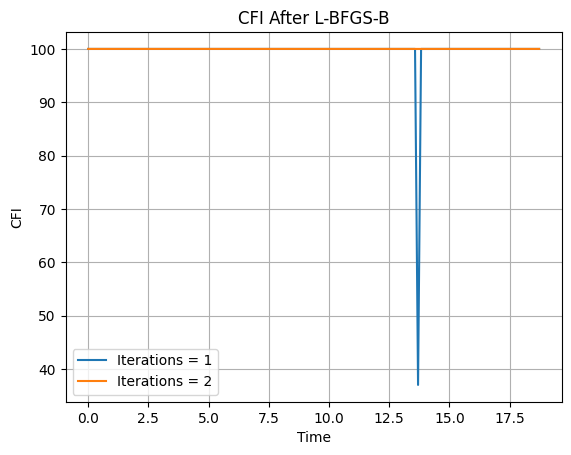

In [10]:
Target_Layer = 1, 2
plt.plot(Optimized_Result[Target_Layer[0], :, 0], Optimized_Result[Target_Layer[0], :, 1], label = f'Iterations = {Target_Layer[0]}')
plt.plot(Optimized_Result[Target_Layer[1], :, 0], Optimized_Result[Target_Layer[1], :, 1], label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

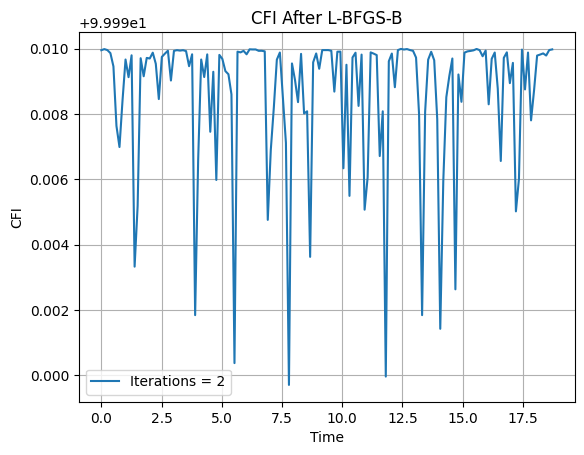

In [11]:
plt.plot(Optimized_Result[1, :, 0], Optimized_Result[Target_Layer[1], :, 1], label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

In [12]:
Optimized_Result[0, :, 1]

array([2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655333,
       2.23655333, 2.23655333, 2.23655333, 2.23655333, 2.23655

Each row of 6-paras => Corresponds to phi

func(phi, paras, gamma_ps)
=> Implement on SLSQP 

Data = [[phi, CFI, theata_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3] ... N]

In [13]:
# Bad case after optimization
# 

Num_of_Layer = 1
Condition = np_.where(Optimized_Result[Num_of_Layer][:, 1] < 98)

print('Index:\n', Condition[0])

print('\n')

Optimized_Result[Num_of_Layer, Condition[0], 1]

print('PHI:\n', Optimized_Result[Num_of_Layer, Condition[0], 0], '\n\nCFI\n', Optimized_Result[Num_of_Layer, Condition[0], 1], '\n\nParas\n', Optimized_Result[Num_of_Layer, Condition[0], 2:])

Index:
 [109]


PHI:
 [13.69744397] 

CFI
 [36.99939774] 

Paras
 [[-2.40674669e-002 -1.15852254e+000  4.00701523e-001  2.26103046e-002
   1.00000000e-100  2.26103293e-002]]
